In [1]:
import torch
import gpytorch
import botorch
from matplotlib import pyplot as plt

from emitutils import toy_beam_size_squared_nd
from utils import unif_random_sample_domain
from utils import build_mesh_domain

from botorch.models import SingleTaskGP
from botorch.sampling.pathwise.prior_samplers import draw_bayes_linear_paths
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.input import InputStandardize
from botorch.models.transforms.outcome import Standardize

In [2]:
def draw_quad_kernel_prior_paths(quad_kernel, nsamples): #quad_kernel is a scaled polynomial(power=2) kernel
    
    c = quad_kernel.offset
    ws = torch.randn(size=[nsamples,1,3])
    
    
    def paths(xs):
        
        if len(xs.shape) == 2 and xs.shape[1] == 1: #xs must be nsamples x npoints x 1 dim
            xs = xs.repeat(nsamples,1,1) #duplicate over batch (sample) dim
            
        X = torch.concat([xs * xs, (2 * c).sqrt() * xs, c.expand(*xs.shape)], dim=2)
        W = ws.repeat(1,xs.shape[1],1)     #ws is nsamples x 1 x 3 dim

        phis = W*X
        return torch.sum(phis, dim=-1) #result tensor is shape nsamples x npoints
    
    return paths
    
    
def draw_product_kernel_prior_paths(model, nsamples):
    
    ndim = model.train_inputs[0].shape[1]
    
    matern_covar_module = model.covar_module.base_kernel.kernels[0] #expects ProductKernel (Matern x Polynomial(dim=2))
    matern_covar_module = gpytorch.kernels.ScaleKernel(matern_covar_module)
    matern_covar_module.outputscale = model.covar_module.outputscale.detach()

    mean_module = gpytorch.means.ZeroMean()

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.noise = model.likelihood.noise.detach()
    
    outcome_transform = None
    input_transform = None

    ########################################
    #build zero-mean (ndim-1)-dimensional GP called matern_model 
    #with kernel matched to the Matern component of the passed model

        
    matern_model = SingleTaskGP(train_X = torch.tensor([[0.]*(ndim-1)]), 
                                train_Y = torch.tensor([[0.]]), 
                                likelihood = likelihood, 
                                mean_module = mean_module,
                                covar_module = matern_covar_module, 
                                 outcome_transform = outcome_transform, 
                                input_transform = input_transform
                               )

    
    ########################################
    
    matern_prior_paths = draw_bayes_linear_paths(
        model=matern_model,
        sample_shape=torch.Size([nsamples]),
        output_transform=None
    )
    
    
    
    quad_kernel = model.covar_module.base_kernel.kernels[1]


    quad_prior_paths = draw_quad_kernel_prior_paths(quad_kernel, nsamples)
    
    def product_kernel_prior_paths(xs):
        return matern_prior_paths(xs[:,:-1]).reshape(nsamples,-1) * quad_prior_paths(xs[:,-1:])
    
    return product_kernel_prior_paths


def draw_product_kernel_post_paths(model, nsamples):

    product_kernel_prior_paths = draw_product_kernel_prior_paths(model, nsamples=nsamples)
    
    train_x = model.train_inputs[0]
#     if model.input_transform is not None:
#         train_x = model.input_transform.untransform(train_x)
    
    train_y = model.train_targets.reshape(-1,1)
#     if model.outcome_transform is not None:
#         train_y = model.outcome_transform.untransform(train_y)[0]
        
    train_y = train_y - model.mean_module(train_x).reshape(train_y.shape)
    
    Knn = model.covar_module.forward(train_x, train_x)
    
    sigma = torch.sqrt(model.likelihood.noise[0])

    K = Knn + sigma**2*torch.eye(Knn.shape[0])

    prior_residual = train_y.repeat(nsamples,1,1).reshape(nsamples,-1) - product_kernel_prior_paths(train_x)
    prior_residual -= sigma*torch.randn_like(prior_residual)

    # v = K.inv_matmul(prior_residual)
    v = torch.linalg.solve(torch.block_diag(*[K.to_dense()]*nsamples), prior_residual.reshape(-1,1)) #replace with cholesky approach
    v = v.reshape(nsamples,-1,1)

    def post_paths(xs):
        if model.input_transform is not None:
            xs = model.input_transform(xs)
        
        K_update = covar_module.forward(train_x, xs) #remove forward

        v_t = v.transpose(1,2)

        update = torch.matmul(v_t, K_update)
        update = update.reshape(nsamples,-1)
        
        prior = product_kernel_prior_paths(xs)
        
        post = prior + update + (model.mean_module(xs).reshape(1,-1)).repeat(nsamples,1)
        if model.outcome_transform is not None:
            post = model.outcome_transform.untransform(post)[0]
            
        return post
    
    return post_paths

In [3]:
domain = torch.tensor([[-2,2],[-1,3], [-4,6]]).float()
train_x = build_mesh_domain(3, domain)[0]
train_y = toy_beam_size_squared_nd(train_x)*1e6
train_y

tensor([[ 29.2800],
        [ 53.5800],
        [ 86.8800],
        [ 29.2800],
        [ 53.5800],
        [ 86.8800],
        [ 68.3200],
        [125.0200],
        [202.7200],
        [  9.7600],
        [ 17.8600],
        [ 28.9600],
        [  9.7600],
        [ 17.8600],
        [ 28.9600],
        [ 48.8000],
        [ 89.3000],
        [144.8000],
        [ 29.2800],
        [ 53.5800],
        [ 86.8800],
        [ 29.2800],
        [ 53.5800],
        [ 86.8800],
        [ 68.3200],
        [125.0200],
        [202.7200]])

In [4]:
covar_module = ( gpytorch.kernels.MaternKernel(nu=2.5,active_dims=list(range(train_x.shape[1]-1))) * 
                    gpytorch.kernels.PolynomialKernel(power = 2, active_dims=[train_x.shape[1]-1] )
         )
covar_module = gpytorch.kernels.ScaleKernel(covar_module)

########################################
#mean

#     constant_constraint = gpytorch.constraints.GreaterThan(50.)
#     constant_constraint = gpytorch.constraints.Positive()
#     constant_prior = gpytorch.priors.GammaPrior(10,10)
constant_constraint = None
constant_prior = None
mean_module = gpytorch.means.ConstantMean(constant_prior = constant_prior, constant_constraint=constant_constraint)
########################################
#noise/likelihood

noise_prior = gpytorch.priors.GammaPrior(1,10)
noise_constraint = None

likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=noise_prior, noise_constraint=noise_constraint)

########################################
#transforms

outcome_transform = Standardize(m=1)
input_transform = InputStandardize(d=train_x.shape[-1])  
#     input_transform = Normalize(d=train_x.shape[-1])  
# outcome_transform = None
# input_transform = None

########################################
#model

model = SingleTaskGP(train_x, train_y, likelihood, mean_module = mean_module, covar_module = covar_module, 
                     outcome_transform = outcome_transform, input_transform = input_transform)

########################################
# Find optimal model hyperparameters

model.train()
model.likelihood.train()



# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)




fit_gpytorch_mll(mll)



model.eval()



C:\Users\Dylan\SLAC\botorch-bax\botorch\models\gpytorch.py:113: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): ProductKernel(
      (kernels): ModuleList(
        (0): MaternKernel(
          (raw_lengthscale_constraint): Positive()
          (distance_module): Distance()
        )
        (1): PolynomialKernel(
          (raw_offset_constraint): Positive()
        )
      )
    )
    (raw_outputscale_constraint): Positive()
  )
  (outcome_transform): Standardize()
  (input_transform): InputStandardize()
)

In [5]:
# xconst = torch.zeros(100).reshape(-1,1)
xconst = torch.ones(100).reshape(-1,1)

# xlin = torch.linspace(-2,2,100).reshape(-1,1)
# # xs_1d_scan = torch.cat((xlin, xconst, xconst), dim=1)
# xs_1d_scan = torch.cat((xconst, xlin, xconst), dim=1)

xlin = torch.linspace(-40,60,100).reshape(-1,1)
xs_1d_scan = torch.cat((xconst, xconst, xlin), dim=1)

In [6]:
#total samples is nsamples * nbatch
nsamples = 100
nbatch = 100



all_pathwise_samples = torch.Tensor([])
all_standard_samples = torch.Tensor([])

for i in range(nbatch):
    print('batch', i)
    
    #pathwise sampling
    post_paths = draw_product_kernel_post_paths(model, nsamples=nsamples)
    
    pathwise_samples = post_paths(xs_1d_scan).detach()

    #standard sampling
    p = model.posterior(xs_1d_scan)
    s = p.rsample(torch.Size([nsamples]))
    standard_samples = s.reshape(nsamples,-1).detach()
    
    #cat results
    all_pathwise_samples = torch.cat((all_pathwise_samples, pathwise_samples), dim=0)
    all_standard_samples = torch.cat((all_standard_samples, standard_samples), dim=0)

batch 0
batch 1


C:\Users\Dylan\SLAC\botorch-bax\botorch\models\gpytorch.py:113: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(
C:\Users\Dylan\Anaconda3\envs\BOTORCH\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\Dylan\Anaconda3\envs\BOTORCH\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\Dylan\Anaconda3\envs\BOTORCH\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
C:\Users\Dylan\Anaconda3\envs\BOTORCH\lib\site-packages\linear_operator\operators\_linear_operator.py:2014: Numerical

batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 49
batch 50
batch 51
batch 52
batch 53
batch 54
batch 55
batch 56
batch 57
batch 58
batch 59
batch 60
batch 61
batch 62
batch 63
batch 64
batch 65
batch 66
batch 67
batch 68
batch 69
batch 70
batch 71
batch 72
batch 73
batch 74
batch 75
batch 76
batch 77
batch 78
batch 79
batch 80
batch 81
batch 82
batch 83
batch 84
batch 85
batch 86
batch 87
batch 88
batch 89
batch 90
batch 91
batch 92
batch 93
batch 94
batch 95
batch 96
batch 97
batch 98
batch 99


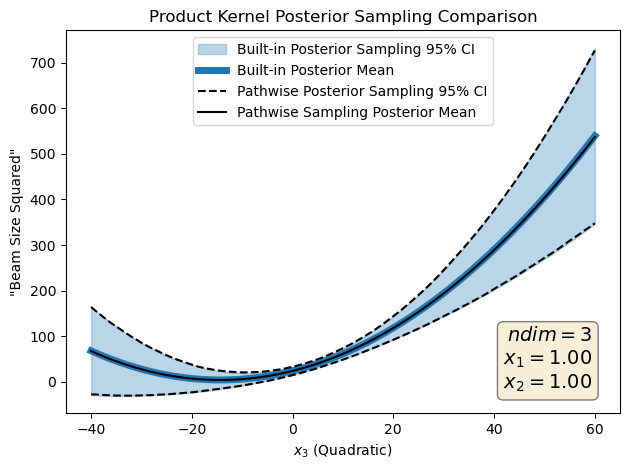

In [7]:
fig, ax = plt.subplots(1)


ax.fill_between(xlin.squeeze(), torch.quantile(all_standard_samples, 0.025, dim=0), torch.quantile(all_standard_samples, 0.975, dim=0), color='C0', alpha = 0.3, label='Built-in Posterior Sampling 95% CI')
ax.plot(xlin.squeeze(), torch.mean(all_standard_samples, dim=0), color='C0', linewidth=5, label='Built-in Posterior Mean')


ax.plot(xlin.squeeze(), torch.quantile(all_pathwise_samples, 0.975, dim=0), c='k', linestyle='--', label='Pathwise Posterior Sampling 95% CI')
ax.plot(xlin.squeeze(), torch.quantile(all_pathwise_samples, 0.025, dim=0), c='k', linestyle='--')

ax.plot(xlin.squeeze(), torch.mean(all_pathwise_samples, dim=0), color='k', label='Pathwise Sampling Posterior Mean')

# ax.scatter(x_obs, y_obs, c='k', label='Observations')
ax.legend(loc='upper center')

ax.set_ylabel('"Beam Size Squared"')
ax.set_title('Product Kernel Posterior Sampling Comparison')


# ax.set_xlabel('$x_1$ (Matern)')
# textstr = '\n'.join((
#     r'$ndim=%d$' % (int(xs_1d_scan.shape[1]), ),
#     r'$x_2=%.2f$' % (xs_1d_scan[0,1], ),
#     r'$x_3=%.2f$' % (xs_1d_scan[0,2], ))
# )

# ax.set_xlabel('$x_2$ (Matern)')
# textstr = '\n'.join((
#     r'$ndim=%d$' % (int(xs_1d_scan.shape[1]), ),
#     r'$x_1=%.2f$' % (xs_1d_scan[0,0], ),
#     r'$x_3=%.2f$' % (xs_1d_scan[0,2], ))
# )

ax.set_xlabel('$x_3$ (Quadratic)')
textstr = '\n'.join((
    r'$ndim=%d$' % (int(xs_1d_scan.shape[1]), ),
    r'$x_1=%.2f$' % (xs_1d_scan[0,0], ),
    r'$x_2=%.2f$' % (xs_1d_scan[0,1], ))
)


# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.95, 0.05, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='bottom', horizontalalignment = 'right', bbox=props)

plt.tight_layout()